In [1]:
import dask as dask 
from dask import compute, persist
from dask.distributed import Client, progress

client = dask.distributed.Client(processes=True, n_workers=6, threads_per_worker=1)
client

Out[1]: <Client: scheduler='tcp://127.0.0.1:43871' processes=6 cores=6>

In [2]:
import dask.dataframe as dd

# Subset of the columns to use
cols = ['Year', 'Month', 'DayOfWeek', 'Distance', 'DepDelay', 'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']

# Create the dataframe
# File location and type

# A small subset of the data of approx 25000 records, has been taken to try out the example
# Data source: http://stat-computing.org/dataexpo/2009/the-data.html
df = dd.read_csv('/dbfs/FileStore/tables/22000.csv', usecols=cols, storage_options={'anon': True})

#df = df.sample(frac=0.2) # we blow out ram otherwise

is_delayed = (df.DepDelay.fillna(16) > 15)
print(is_delayed)

df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)
del df['DepDelay']

df, is_delayed = persist(df, is_delayed)
progress(df, is_delayed)
df.head(10)

Dask Series Structure:
npartitions=1
 bool
 ...
Name: DepDelay, dtype: bool
Dask Name: gt, 6 tasks
[ ] | 0% Completed | 0.0s[ ] | 0% Completed | 0.1s[ ] | 0% Completed | 0.2s[ ] | 0% Completed | 0.3s[ ] | 0% Completed | 0.4s[ ] | 0% Completed | 0.5s[ ] | 0% Completed | 0.6s[ ] | 0% Completed | 0.7s[ ] | 0% Completed | 0.8s[ ] | 0% Completed | 0.9s[########################################] | 100% Completed | 1.0sOut[2]: 
 Year Month DayOfWeek ... Origin Dest Distance
0 2000 11 1 ... DTW ORD 235
1 2000 11 2 ... DTW ORD 235
2 2000 11 3 ... DTW ORD 235
3 2000 11 3 ... BOS LGA 185
4 2000 11 4 ... BOS LGA 185
5 2000 11 5 ... BOS LGA 185
6 2000 11 7 ... BOS LGA 185
7 2000 11 1 ... BOS LGA 185
8 2000 11 2 ... BOS LGA 185
9 2000 11 3 ... BOS LGA 185

[10 rows x 8 columns]

In [3]:
print(is_delayed.head(10))
df2 = dd.get_dummies(df.categorize()).persist()


0 False
1 False
2 False
3 False
4 False
5 True
6 False
7 False
8 False
9 False
Name: DepDelay, dtype: bool

In [4]:
data_train, data_test = df2.random_split([0.9, 0.1], 
                                         random_state=1234)
labels_train, labels_test = is_delayed.random_split([0.9, 0.1], 
                                                    random_state=1234)

In [5]:
%%time
import dask_xgboost as dxgb

params = {'objective': 'binary:logistic', 'nround': 1000, 
          'max_depth': 16, 'nthread': 4, 'eta': 0.01, 'subsample': 0.5, 
          'min_child_weight': 1}

bst = dxgb.train(client, params, data_train, labels_train)
bst

CPU times: user 2.73 s, sys: 485 ms, total: 3.22 s
Wall time: 33.5 s

In [6]:
# Use normal XGBoost model with normal Pandas
import xgboost as xgb
dtest = xgb.DMatrix(data_test.head())
bst.predict(dtest)


Out[6]: 
array([0.4622652 , 0.46763694, 0.50574255, 0.50448364, 0.50429285],
 dtype=float32)

In [7]:
# Or use dask-xgboost to predict in parallel across the cluster
predictions = dxgb.predict(client, bst, data_test).persist()
predictions

Out[7]: dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,)>

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve
print(roc_auc_score(labels_test.compute(), 
                    predictions.compute()))

0.7132152561853731

In [9]:
import matplotlib.pyplot as plt
#%matplotlib inline # matplotlib inline doesnt work this way in Databricks

fpr, tpr, _ = roc_curve(labels_test.compute(), predictions.compute())
tpr

Out[9]: 
array([0.00000000e+00, 6.16903146e-04, 3.70141888e-03, ...,
 9.95064775e-01, 9.98149291e-01, 1.00000000e+00])

In [10]:
fpr

Out[10]: 
array([0.00000000e+00, 1.71732784e-04, 1.71732784e-04, ...,
 9.63592650e-01, 9.89352567e-01, 1.00000000e+00])

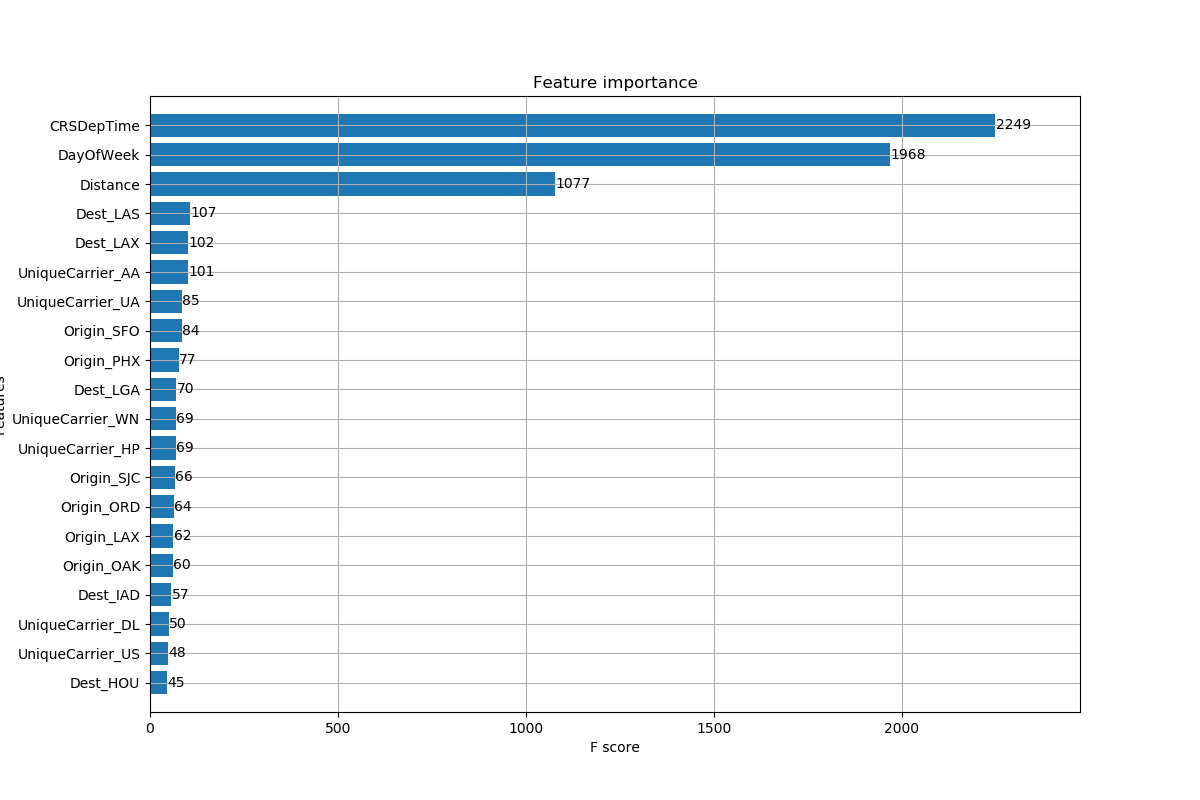

In [11]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=20)
display(fig)

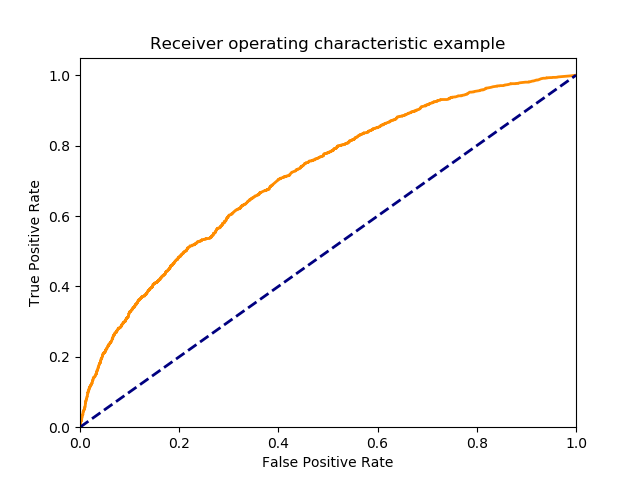

In [12]:
# Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
plt.figure(figsize=(8, 8))
lw = 2
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
#ax.set_legend(loc="lower right")
# Doesnt work yet - trying to resolve the display ...
# Based on: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html
display(fig)